## Model Training

**  Este notebook se centra en la Construcción, Ajuste y Evaluación de Modelos para predecir el Alto Riesgo de Ausentismo. Con un enfoque estratégico en la gestión de riesgos, la selección de modelos (ej., XGBoost) y el ajuste de hiperparámetros se optimizan para el Recall y F1 Score, buscando minimizar los Falsos Negativos (fallar en detectar un caso de Alto Ausentismo). Los datos preprocesados, que incluyen la separación entre causas ICD y variables operacionales, se utilizan para entrenar los modelos, cuyo resultado final se evalúa para proveer a RR.HH. un Sistema de Alerta Temprana con la mayor precisión posible.

In [ ]:
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
df = pd.read_csv('../data/raw/work_absenteeism_original.csv')

In [ ]:
target_column = 'absenteeism_time_in_hours'
column_names = [column for column in df.columns]
df.columns = [x.lower() for x in df.columns]
df.columns = df.columns.str.replace("[ ]", "_", regex=True)
column_names = [column for column in df.columns]

In [ ]:
columns_to_drop = ['id', 'body_mass_index']
numerical_columns = ['transportation_expense', 'distance_from_residence_to_work', 'service_time', 'age', 'work_load_average/day', 'hit_target', 'son', 'pet', 'weight', 'height', 'education']
categorical_columns = ['disciplinary_failure', 'social_drinker', 'social_smoker','month_of_absence', 'day_of_the_week', 'seasons', 'reason_for_absence']

In [ ]:
class DropColumnsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()
        # Drop only the columns that exist in the DataFrame
        columns_to_drop = [col for col in self.columns_to_drop if col in X.columns]
        if columns_to_drop:
            X = X.drop(columns_to_drop, axis=1)
        return X

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            raise ValueError("input_features must be provided")
        return [col for col in input_features if col not in self.columns_to_drop]


class IQRClippingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.lower_bounds_ = {}
        self.upper_bounds_ = {}

    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        for col in X.columns:
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)
            IQR = Q3 - Q1
            self.lower_bounds_[col] = Q1 - 1.5 * IQR
            self.upper_bounds_[col] = Q3 + 1.5 * IQR
        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()
        for col in X.columns:
            X[col] = X[col].clip(lower=self.lower_bounds_.get(col),
                                upper=self.upper_bounds_.get(col))
        return X

    def get_feature_names_out(self, input_features=None):
        return input_features if input_features is not None else self.columns_

class ToStringTransformer(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()
        for col in X.columns:
            X[col] = X[col].astype(str)
        return X

    def get_feature_names_out(self, input_features=None):
        return input_features if input_features is not None else []

In [ ]:
pipeline = Pipeline([
    ('drop_columns', DropColumnsTransformer(columns_to_drop)),
    ('preprocess', ColumnTransformer(
        transformers=[
            ('numerical', Pipeline([
                ('iqr_clipping', IQRClippingTransformer()),
                ('scaling', StandardScaler())
            ]), numerical_columns),
            ('categorical', Pipeline([
                ('to_string', ToStringTransformer()),
                ('one_hot', OneHotEncoder(sparse=False, handle_unknown='ignore'))
            ]), categorical_columns)
        ],
        remainder='passthrough'
    ))
])

In [ ]:
X = df.drop(target_column, axis=1)
y = df[target_column]

median_absentism_value = y.median()
print(f"Median of clipped training target: {median_absentism_value}")
y = (y > median_absentism_value).astype(int)

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



Median of clipped training target: 3.0



Results for Logistic Regression:
Accuracy: 0.80
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.79      0.82        81
           1       0.76      0.82      0.79        67

    accuracy                           0.80       148
   macro avg       0.80      0.81      0.80       148
weighted avg       0.81      0.80      0.80       148



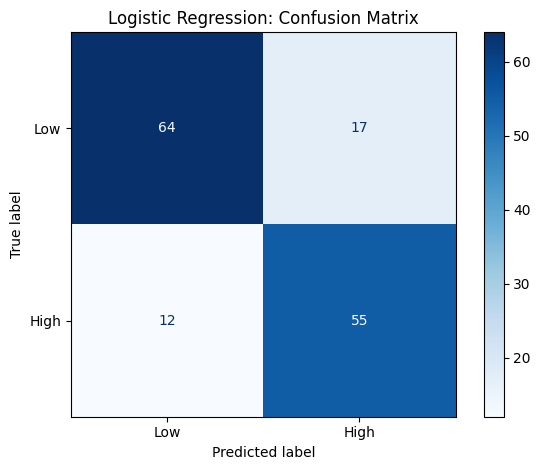


Results for Random Forest Classifier:
Accuracy: 0.79
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.77      0.80        81
           1       0.74      0.82      0.78        67

    accuracy                           0.79       148
   macro avg       0.79      0.79      0.79       148
weighted avg       0.80      0.79      0.79       148



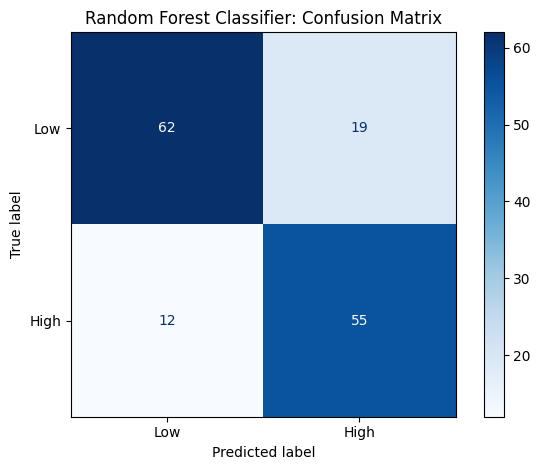


Results for Neural Network:
Accuracy: 0.72
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.74      0.74        81
           1       0.69      0.69      0.69        67

    accuracy                           0.72       148
   macro avg       0.71      0.71      0.71       148
weighted avg       0.72      0.72      0.72       148



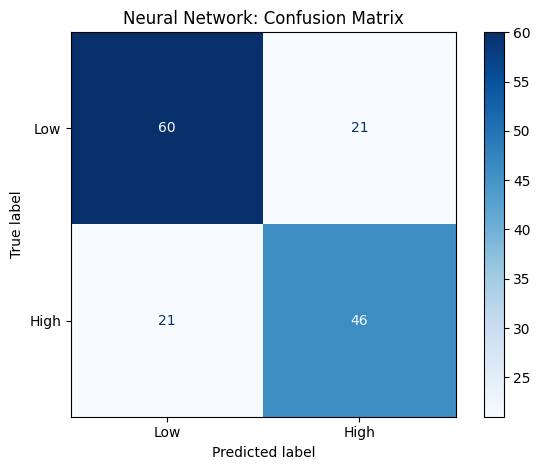

In [ ]:
# Define two regression models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest Classifier': RandomForestClassifier(random_state=42, n_estimators=100),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam',
                                   alpha=0.01, max_iter=1000, random_state=42, early_stopping=True)
}

# Fit and evaluate each model
for model_name, model in models.items():
    # Create a full pipeline with preprocessing and the current model
    full_pipeline = Pipeline([
        ('preprocess', pipeline),
        ('regressor', model)
    ])

    # Fit the pipeline
    full_pipeline.fit(X_train, y_train)

    # Make predictions on test set
    y_pred = full_pipeline.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nResults for {model_name}:")
    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Create confusion matrix plot
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low', 'High'])
    disp.plot(cmap='Blues')
    plt.title(f'{model_name}: Confusion Matrix')
    plt.tight_layout()
    plt.show()